In [1]:
import pandas as pd
import numpy as np
import sqlite3
import datetime
import sklearn
import sqlalchemy as sa
from tqdm import tqdm_notebook
import itertools
import pickle
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn import metrics

In [2]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

import operator
import gc

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', -1)

In [4]:
%matplotlib inline

In [5]:
%%time
train_raw = pd.read_feather('../../data/prepaired_dataset/train_v2.fth')

CPU times: user 1.41 s, sys: 1.02 s, total: 2.43 s
Wall time: 2.46 s


In [6]:
train_raw = train_raw.loc[train_raw.label != -1].copy()

In [7]:
rng = np.random.RandomState(seed=1)

In [8]:
uid_train, uid_val = train_test_split(sorted(train_raw['user_id'].unique()), test_size = 0.2, random_state = rng)

In [9]:
set(uid_train) & set(uid_val)

set()

говнокод

In [10]:
sd = sorted(train_raw['short_date'].unique())

In [11]:
dates_chunk = sd[:4], sd[4:8], sd[8:12], sd[12:16], sd[16:20], sd[20:24], sd[24:28], sd[28:32]

In [12]:
drop_cols = ['event_id', 'user_id', 'event_time', 'short_date']

In [13]:
params = {'colsample_bytree': 0.7,
 'max_depth': 5,
 'n_estimators': 150,
 'reg_alpha': 0.03,
 'subsample': 0.6,
 'objective': 'binary:logistic',
 'njobs': 16}

In [14]:
dtrains, dvals = [], []
for dates_train, dates_val in tqdm_notebook(list(zip(dates_chunk[:-1], dates_chunk[1:]))):
    t = train_raw.loc[train_raw['user_id'].isin(uid_train)]
    t = t.query(f'(short_date >= {dates_train[0]}) and (short_date <= {dates_train[1]})').drop(drop_cols, axis = 1)
    dtrain = xgb.DMatrix(t.drop('label', axis = 1), label=t['label'], missing=np.NAN)
    t = train_raw.loc[train_raw['user_id'].isin(uid_val)]
    t = t.query(f'(short_date >= {dates_val[0]}) and (short_date <= {dates_val[1]})').drop(drop_cols, axis = 1)
    dval = xgb.DMatrix(t.drop('label', axis = 1), label=t['label'], missing=np.NAN)
    dtrains.append(dtrain)
    dvals.append(dval)

HBox(children=(IntProgress(value=0, max=7), HTML(value='')))

In [15]:
del t, train_raw
gc.collect()

5677

In [16]:
num_round = 250
models = []

#for chunk_params in tqdm_notebook([{k:v for k, v in x} for x in cv_params_list]):
for n, (dates_train, dates_val, dtrain, dval) in tqdm_notebook(list(enumerate(zip(dates_chunk[:-1], dates_chunk[1:], dtrains, dvals)))):
    evallist = [(dtrain, 'train'), (dval, 'eval')]
    bst = xgb.train(params, dtrain, num_round, evallist, verbose_eval=100, early_stopping_rounds = 20)
    auc = roc_auc_score(dval.get_label(), bst.predict(dval))
    print(f'Dates train: {min(dates_train)}-{max(dates_train)}. Auc: {auc}')
    models.append((bst, auc))

HBox(children=(IntProgress(value=0, max=7), HTML(value='')))

[0]	train-error:0.004299	eval-error:0.003402
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 20 rounds.
Stopping. Best iteration:
[7]	train-error:0.003478	eval-error:0.002699

Dates train: 20171029-20171101. Auc: 0.9578441454274363
[0]	train-error:0.003008	eval-error:0.00427
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 20 rounds.
Stopping. Best iteration:
[9]	train-error:0.002623	eval-error:0.003425

Dates train: 20171102-20171105. Auc: 0.9399378489676073
[0]	train-error:0.003319	eval-error:0.004269
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 20 rounds.
Stopping. Best iteration:
[16]	train-error:0.002613	eval-error:0.00357

Dates train: 20171106-20171109. Auc: 0.9679426688163885
[0]	train-error:0.003009	eval-error:0.003112
Mu

In [18]:
aucs = []
for n, (m, _) in enumerate(models):
    auc = roc_auc_score(dval.get_label(), m.predict(dval))
    aucs.append(auc)
    print(n, auc)

0 0.9621926913089598
1 0.962568757469725
2 0.965530488478024
3 0.9655431480121531
4 0.9718855746108543
5 0.9679323800884128
6 0.9617953259320058


In [20]:
np.argmax(aucs)

4

In [25]:
bst = models[4][0]
sorted(bst.get_score(importance_type = 'gain').items(), key = lambda x: x[1], reverse = True)

[('channel_indicator_desc_is_MOBILEAPI', 35.39792),
 ('cdf_s_127', 32.53760748),
 ('transfer_know_recip_squared', 25.377529999999997),
 ('cdf_s_129', 19.001917588235294),
 ('channel_indicator_desc_is_WEBAPI', 18.512453999999998),
 ('data_i_154', 13.837689511627902),
 ('one_region', 12.943455384615387),
 ('cat_new_prov', 11.419623636363637),
 ('op_type', 9.396346500000002),
 ('transfer_recip_age', 8.221985),
 ('user_id_MBK', 7.922705),
 ('cat_new_ip', 7.467655368421052),
 ('cdf_s_133', 7.4574099375000005),
 ('transfer_for_relative', 7.268498000000001),
 ('cdf_s_134', 7.209785571428573),
 ('user_id_digit_only', 6.23708),
 ('amount', 6.057520814814815),
 ('client_age', 5.95775619019608),
 ('ip_isp', 5.849417171428572),
 ('cdf_s_130', 5.79799375862069),
 ('log_amount', 5.747212368421053),
 ('cdf_s_135', 5.700575609090909),
 ('cumulative_sum_total', 5.598316734374998),
 ('know_recip_card_age', 5.316865),
 ('event_hour', 5.28917983122449),
 ('transfer_age_diff', 5.273763310344827),
 ('event_

In [ ]:
folder = '../../data/models/simple_baseline/v1/'
!mkdir -p $folder

In [ ]:
with open(folder + 'models.pkl', 'wb') as f:
    pickle.dump(models, f)

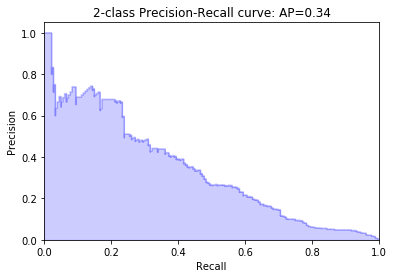

0.33816436414313783

In [26]:
y_val = dval.get_label()
preds = bst.predict(dval)
average_precision = average_precision_score(y_val, preds)
precision, recall, thresholds = precision_recall_curve(y_val, preds)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.show()

metrics.auc(recall, precision)